In [1]:
import pip
! python -m pip install /Users/sienkadounia/lab/ai-futures/Project/devinterp

Processing ./devinterp
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for devinterp: filename=devinterp-0.2.0-py3-none-any.whl size=36054 sha256=1bb99004f4d9323b48bea63dc67c49ec2be42db8c075c9d89bf8fb58b3992882
  Stored in directory: /private/var/folders/z1/4ncpvz_901x1gm_4cv8jlcwr0000gn/T/pip-ephem-wheel-cache-edcmgwnx/wheels/d1/77/c6/79d956127053bf417b2be69c96cf13206452a78ec4d772f07c
Successfully built devinterp
  Attempting uninstall: devinterp
    Found existing installation: devinterp 0.2.0
    Uninstalling devinterp-0.2.0:
      Successfully uninstalled devinterp-0.2.0


In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import devinterp
from devinterp.slt import estimate_learning_coeff, estimate_learning_coeff_with_summary
from devinterp.slt import llc
from devinterp.slt.mala import MalaAcceptanceRate
from devinterp.optim.sgld import SGLD
from devinterp.utils import plot_trace, optimal_temperature
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, Subset, DataLoader, Dataset

In [3]:
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

else:
    mps_device = torch.device("mps")

device = 'mps' # 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
checkpoints_path = '/Users/sienkadounia/lab/ai-futures/Project/ewdd/'
label_noise_path = '/Users/sienkadounia/lab/ai-futures/Project/label_noise/'
rlcts_path = '/Users/sienkadounia/lab/checkpoints/rlcts/ewdd/'
mwdd_path = '/Users/sienkadounia/lab/ai-futures/Project/mwdd'

In [5]:
batch_size = 1000
epochs = 400
num_classes = 10
lr = 0.002
use_label_noise =False
augmented = False
use_adam_op = False
input_size = 28 * 28  # MNIST images are 28x28
output_size = 10  # 10 classes

In [6]:
# Load and preprocess the MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
mnist_train = datasets.MNIST('data/',
                             train=True,
                             download=True,
                             transform=transform)
mnist_test = datasets.MNIST('data/',
                            train=False,
                            download=True,
                            transform=transform)

# Randomly select 40k samples from the training set
indices = torch.randperm(len(mnist_train))[:40000]
train_data = torch.utils.data.Subset(mnist_train, indices)

train_loader = DataLoader(train_data,
                          batch_size=batch_size, 
                          shuffle=True)
test_loader = DataLoader(mnist_test,
                        batch_size = batch_size,
                        shuffle =True)

In [41]:
class FCNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FCNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.view(-1, input_size) 
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [30]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [42]:
models = []
hidden_sizes = [2, 4, 8, 16, 32 ,64, 128]
for k in range (len(hidden_sizes)):
    hidden_size = hidden_sizes[k]
    model = FCNN(input_size, hidden_size, output_size).to(device)
    model.load_state_dict(torch.load(mwdd_path + 'fccnn_'+str(hidden_size)+'_fixed.pth'))
    models.append(model)

In [32]:
all_calib_results = []
for i in range(len(hidden_sizes)):
    EPSILONS = [1e-4, 3e-5, 1e-5, 1e-6, 1e-7, 1e-8]
    GAMMAS = [1.0, 10.0, 100.0]
    NUM_CHAINS = 1
    NUM_DRAWS = 500
    calib_results = {}

    model = models[i]
    criterion = nn.CrossEntropyLoss(reduction='mean').to(device)

    print(f'Running MALA calibration for FCNN Model with {count_parameters(model)}')

    def estimate_mala_sweeper(model):
        for epsilon in EPSILONS:
            for gamma in GAMMAS:
                mala_estimator = MalaAcceptanceRate(
                    num_chains=NUM_CHAINS,
                    num_draws=NUM_DRAWS,
                    temperature=optimal_temperature(train_loader),
                    learning_rate=epsilon,
                    device=device,
                )

                result = estimate_learning_coeff_with_summary(
                    model,
                    train_loader,
                    criterion=criterion,
                    optimizer_kwargs=dict(
                        lr=epsilon, localization=gamma, temperature=optimal_temperature(train_loader)
                    ),
                    sampling_method=SGLD,
                    num_chains=NUM_CHAINS,
                    num_draws=NUM_DRAWS,
                    callbacks=[mala_estimator],
                    verbose=False,
                    online=True,
                )
                mala_acceptance_rate_mean = mala_estimator.sample()["mala_accept/mean"]
                calib_results[(epsilon, gamma)] = result
                print(
                    f"epsilon {epsilon}, gamma {gamma}, mala rate: {mala_acceptance_rate_mean}"
                )

    estimate_mala_sweeper(model)

    torch.save(calib_results, rlcts_path + 'calib_results.pt')
    all_calib_results.append(calib_results)

Running MALA calibration for FCNN Model with 1600
epsilon 0.0001, gamma 1.0, mala rate: 0.7287842035293579
epsilon 0.0001, gamma 10.0, mala rate: 0.5614064931869507
epsilon 0.0001, gamma 100.0, mala rate: 0.43637627363204956
epsilon 3e-05, gamma 1.0, mala rate: 0.8354129195213318
epsilon 3e-05, gamma 10.0, mala rate: 0.7710245847702026
epsilon 3e-05, gamma 100.0, mala rate: 0.4292408227920532
epsilon 1e-05, gamma 1.0, mala rate: 0.899661123752594
epsilon 1e-05, gamma 10.0, mala rate: 0.8479490876197815
epsilon 1e-05, gamma 100.0, mala rate: 0.5761594176292419
epsilon 1e-06, gamma 1.0, mala rate: 0.9113941788673401
epsilon 1e-06, gamma 10.0, mala rate: 0.8834526538848877
epsilon 1e-06, gamma 100.0, mala rate: 0.8621942400932312
epsilon 1e-07, gamma 1.0, mala rate: 0.9060407280921936
epsilon 1e-07, gamma 10.0, mala rate: 0.8934714794158936
epsilon 1e-07, gamma 100.0, mala rate: 0.8846835494041443
epsilon 1e-08, gamma 1.0, mala rate: 0.9006694555282593
epsilon 1e-08, gamma 10.0, mala rate

In [33]:
import matplotlib.pyplot as plt

In [34]:
def estimate_llcs_sweeper(model, epsilons, gammas):
    results = {}
    for epsilon in epsilons:
        for gamma in gammas:
            optim_kwargs = dict(lr=epsilon, noise_level=1.0, localization=gamma)
            pair = (epsilon, gamma)
            results[pair] = estimate_learning_coeff_with_summary(
                model=model,
                loader=train_loader,
                criterion=criterion,
                sampling_method=SGLD,
                optimizer_kwargs=optim_kwargs,
                num_chains=NUM_CHAINS,
                num_draws=NUM_DRAWS,
                device=device,
                online=True,
            )
    return results


def plot_single_graph(result, title=""):
    llc_color = "teal"
    fig, axs = plt.subplots(1, 1)
    # plot loss traces
    loss_traces = result["loss/trace"]
    for trace in loss_traces:
        init_loss = trace[0]
        zeroed_trace = trace - init_loss
        sgld_steps = list(range(len(trace)))
        axs.plot(sgld_steps, zeroed_trace)

    # plot llcs
    means = result["llc/means"]
    stds = result["llc/stds"]
    sgld_steps = list(range(len(means)))
    axs2 = axs.twinx()
    axs2.plot(
        sgld_steps,
        means,
        color=llc_color,
        linestyle="--",
        linewidth=2,
        label=f"llc",
        zorder=3,
    )
    axs2.fill_between(
        sgld_steps, means - stds, means + stds, color=llc_color, alpha=0.3, zorder=2
    )

    # center zero, assume zero is in the range of both y axes already
    y1_min, y1_max = axs.get_ylim()
    y2_min, y2_max = axs2.get_ylim()
    y1_zero_ratio = abs(y1_min) / (abs(y1_min) + abs(y1_max))
    y2_zero_ratio = abs(y2_min) / (abs(y2_min) + abs(y2_max))
    percent_to_add = abs(y1_zero_ratio - y2_zero_ratio)
    y1_amt_to_add = (y1_max - y1_min) * percent_to_add
    y2_amt_to_add = (y2_max - y2_min) * percent_to_add
    if y1_zero_ratio < y2_zero_ratio:
        # add to bottom of y1 and top of y2
        y1_min -= y1_amt_to_add
        y2_max += y2_amt_to_add
    elif y2_zero_ratio < y1_zero_ratio:
        # add to bottom of y2 and top of y1
        y2_min -= y2_amt_to_add
        y1_max += y1_amt_to_add
    axs.set_ylim(y1_min, y1_max)
    axs2.set_ylim(y2_min, y2_max)
    axs.set_xlabel("SGLD time step")
    axs.set_ylabel("loss")
    axs2.set_ylabel("llc", color=llc_color)
    axs2.tick_params(axis="y", labelcolor=llc_color)
    axs.axhline(color="black", linestyle=":")
    fig.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()


def plot_sweep_single_model(results, epsilons, gammas, **kwargs):
    llc_color = "teal"
    fig, axs = plt.subplots(len(epsilons), len(gammas))

    for i, epsilon in enumerate(epsilons):
        for j, gamma in enumerate(gammas):
            result = results[(epsilon, gamma)]
            # plot loss traces
            loss_traces = result["loss/trace"]
            for trace in loss_traces:
                init_loss = trace[0]
                zeroed_trace = trace - init_loss
                sgld_steps = list(range(len(trace)))
                axs[i, j].plot(sgld_steps, zeroed_trace)

            # plot llcs
            means = result["llc/means"]
            stds = result["llc/stds"]
            sgld_steps = list(range(len(means)))
            axs2 = axs[i, j].twinx()
            axs2.plot(
                sgld_steps,
                means,
                color=llc_color,
                linestyle="--",
                linewidth=2,
                label=f"llc",
                zorder=3,
            )
            axs2.fill_between(
                sgld_steps,
                means - stds,
                means + stds,
                color=llc_color,
                alpha=0.3,
                zorder=2,
            )

            # center zero, assume zero is in the range of both y axes already
            y1_min, y1_max = axs[i, j].get_ylim()
            y2_min, y2_max = axs2.get_ylim()
            y1_zero_ratio = abs(y1_min) / (abs(y1_min) + abs(y1_max))
            y2_zero_ratio = abs(y2_min) / (abs(y2_min) + abs(y2_max))
            percent_to_add = abs(y1_zero_ratio - y2_zero_ratio)
            y1_amt_to_add = (y1_max - y1_min) * percent_to_add
            y2_amt_to_add = (y2_max - y2_min) * percent_to_add
            if y1_zero_ratio < y2_zero_ratio:
                # add to bottom of y1 and top of y2
                y1_min -= y1_amt_to_add
                y2_max += y2_amt_to_add
            elif y2_zero_ratio < y1_zero_ratio:
                # add to bottom of y2 and top of y1
                y2_min -= y2_amt_to_add
                y1_max += y1_amt_to_add
            axs[i, j].set_ylim(y1_min, y1_max)
            axs2.set_ylim(y2_min, y2_max)

            axs[i, j].set_title(f"$\epsilon$ = {epsilon} : $\gamma$ = {gamma}, batch_size = {batch_size}, epochs = {epochs}, lr = {lr}, model_size= {count_parameters(model)}")
            # only show x axis label on last row
            if i == len(epsilons) - 1:
                axs[i, j].set_xlabel("SGLD time step")
            axs[i, j].set_ylabel("loss")
            axs2.set_ylabel("llc", color=llc_color)
            axs2.tick_params(axis="y", labelcolor=llc_color)
    if kwargs["title"]:
        fig.suptitle(kwargs["title"], fontsize=16)
    plt.tight_layout()
    plt.show()

In [ ]:
for calib_results in all_calib_results:
    plt.rcParams["figure.figsize"] = (50, 40)
    plot_sweep_single_model(
    calib_results,
    EPSILONS,
    GAMMAS,
    title="Calibration sweep of FCNN on the MNIST data for lr ($\\epsilon$) and localization ($\\gamma$)",
)

In [43]:
more_chains_all_calib_results = []
all_mala_acc_rates = []
for i in range(len(hidden_sizes)):
    EPSILONS = [1e-4, 3e-5, 1e-5, 1e-6, 1e-7, 1e-8]
    GAMMAS = [1.0, 10.0, 100.0]
    NUM_CHAINS = 5
    NUM_DRAWS = 1000
    calib_results = {}
    mala_acc_rates = []

    model = models[i]
    criterion = nn.CrossEntropyLoss(reduction='mean').to(device)

    print(f'Running MALA calibration for FCNN Model with {count_parameters(model)}')

    def estimate_mala_sweeper(model):
        for epsilon in EPSILONS:
            for gamma in GAMMAS:
                mala_estimator = MalaAcceptanceRate(
                    num_chains=NUM_CHAINS,
                    num_draws=NUM_DRAWS,
                    temperature=optimal_temperature(train_loader),
                    learning_rate=epsilon,
                    device=device,
                )

                result = estimate_learning_coeff_with_summary(
                    model,
                    train_loader,
                    criterion=criterion,
                    optimizer_kwargs=dict(
                        lr=epsilon, localization=gamma, temperature=optimal_temperature(train_loader)
                    ),
                    sampling_method=SGLD,
                    num_chains=NUM_CHAINS,
                    num_draws=NUM_DRAWS,
                    callbacks=[mala_estimator],
                    verbose=False,
                    online=True,
                )
                mala_acceptance_rate_mean = mala_estimator.sample()["mala_accept/mean"]
                mala_acc_rates.append(mala_acceptance_rate_mean)
                calib_results[(epsilon, gamma)] = result
                print(
                    f"epsilon {epsilon}, gamma {gamma}, mala rate: {mala_acceptance_rate_mean}"
                )

    estimate_mala_sweeper(model)

    torch.save(calib_results, rlcts_path + '10_chains_calib_results.pt')
    more_chains_all_calib_results.append(calib_results)
    all_mala_acc_rates.append(mala_acc_rates)

Running MALA calibration for FCNN Model with 1600
epsilon 0.0001, gamma 1.0, mala rate: 0.7221306562423706
epsilon 0.0001, gamma 10.0, mala rate: 0.5785762071609497
epsilon 0.0001, gamma 100.0, mala rate: 0.5192403197288513
epsilon 3e-05, gamma 1.0, mala rate: 0.7795318365097046
epsilon 3e-05, gamma 10.0, mala rate: 0.7116860747337341
epsilon 3e-05, gamma 100.0, mala rate: 0.5127459168434143
epsilon 1e-05, gamma 1.0, mala rate: 0.8193890452384949
epsilon 1e-05, gamma 10.0, mala rate: 0.8260107636451721
epsilon 1e-05, gamma 100.0, mala rate: 0.6092385053634644
epsilon 1e-06, gamma 1.0, mala rate: 0.8819879293441772
epsilon 1e-06, gamma 10.0, mala rate: 0.8583958148956299
epsilon 1e-06, gamma 100.0, mala rate: 0.8476064205169678
epsilon 1e-07, gamma 1.0, mala rate: 0.8763826489448547
epsilon 1e-07, gamma 10.0, mala rate: 0.8824042677879333
epsilon 1e-07, gamma 100.0, mala rate: 0.8720222115516663
epsilon 1e-08, gamma 1.0, mala rate: 0.880465030670166
epsilon 1e-08, gamma 10.0, mala rate:

In [ ]:
for calib_results in more_chains_all_calib_results:
   
    model = models[i]
    plt.rcParams["figure.figsize"] = (60, 40)
    plot_sweep_single_model(
    calib_results,
    EPSILONS,
    GAMMAS,
    title="Calibration sweep of FCNN model on MNIST for lr ($\\epsilon$) and localization ($\\gamma$)",
)

In [7]:
calib_results = torch.load(rlcts_path + '10_chains_calib_results.pt')

In [77]:
all_mala_rates = []
for calib_result in calib_results:
    mala_rate = calib_results[calib_result]['mala_accept/mean']
    all_mala_rates.append(mala_rate)
all_mala_rates

[0.43431166,
 0.12805213,
 0.34407678,
 0.48656005,
 0.25603536,
 0.13637763,
 0.508273,
 0.4133404,
 0.07083141,
 0.52625084,
 0.556993,
 0.41710252,
 0.5485178,
 0.4912323,
 0.5130474,
 0.5162519,
 0.54733163,
 0.50695527]

In [91]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn

In [92]:
golden_ratio = (5**0.5 - 1) / 2
WIDTH = 3.25
HEIGHT = WIDTH * golden_ratio
some_multiplier_1 = 1.5
some_multiplier_2 = 1.5

In [82]:
all_mala_rates = np.array(all_mala_rates)
all_mala_rates_for_eps = all_mala_rates.reshape(6, 3)
all_mala_rates_for_gams = all_mala_rates.reshape(3, 6)

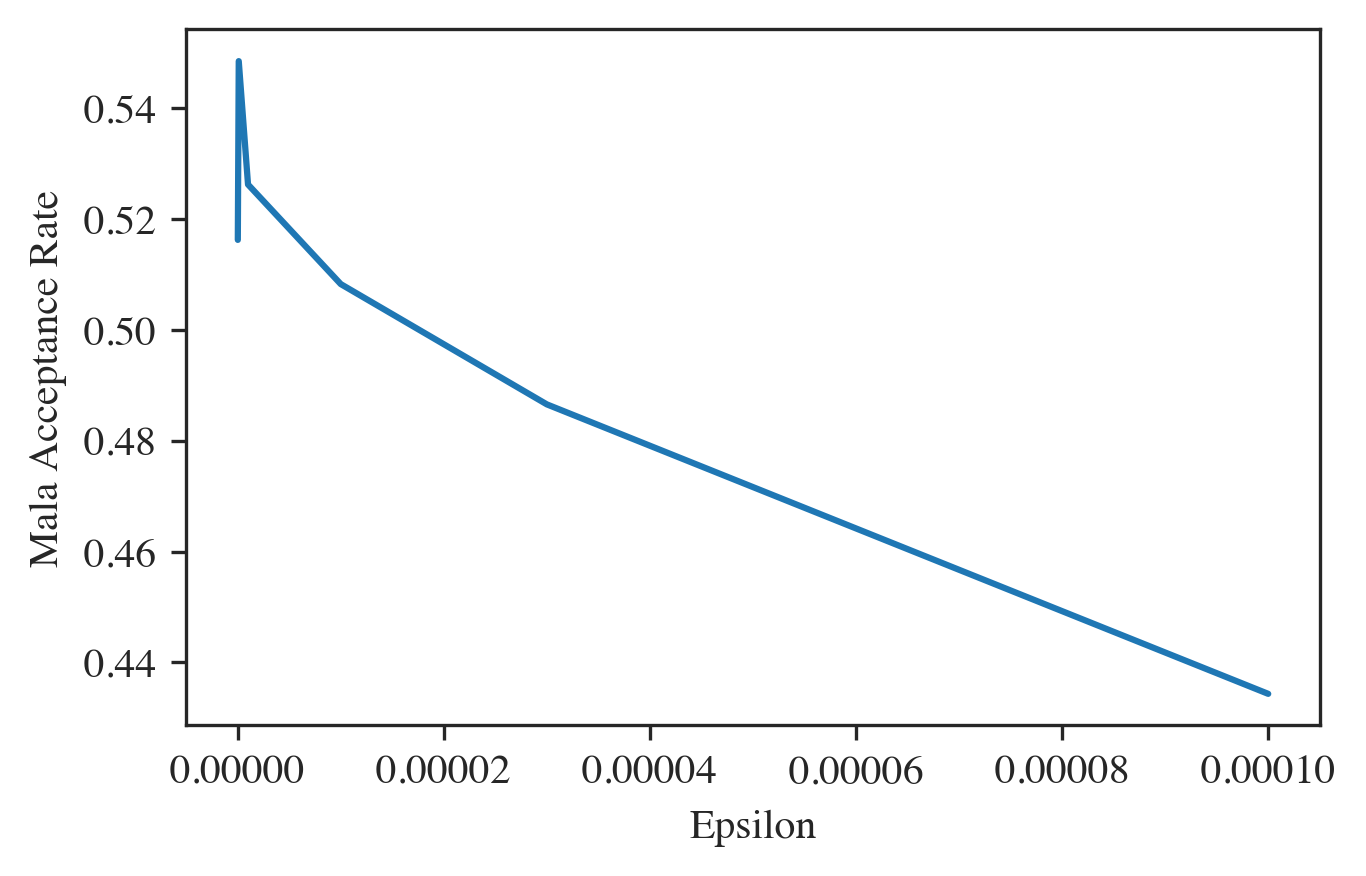

In [94]:
mala_for_eps = []
for i in range(len(all_mala_rates_for_eps)):
    mala_for_eps.append(all_mala_rates_for_eps[i][0])

plt.figure(figsize = (some_multiplier_1 * WIDTH, some_multiplier_2 * HEIGHT))   
plt.plot(EPSILONS, mala_for_eps)
plt.ylabel('Mala Acceptance Rate')
plt.xlabel('Epsilon')
seaborn.set_style("ticks")
plt.rcParams["font.family"] = "Times"
plt.rcParams['figure.dpi'] = 300
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('axes', labelsize=8)
plt.rc('legend', fontsize=8)
plt.rc('axes', titlesize=10)
plt.show()

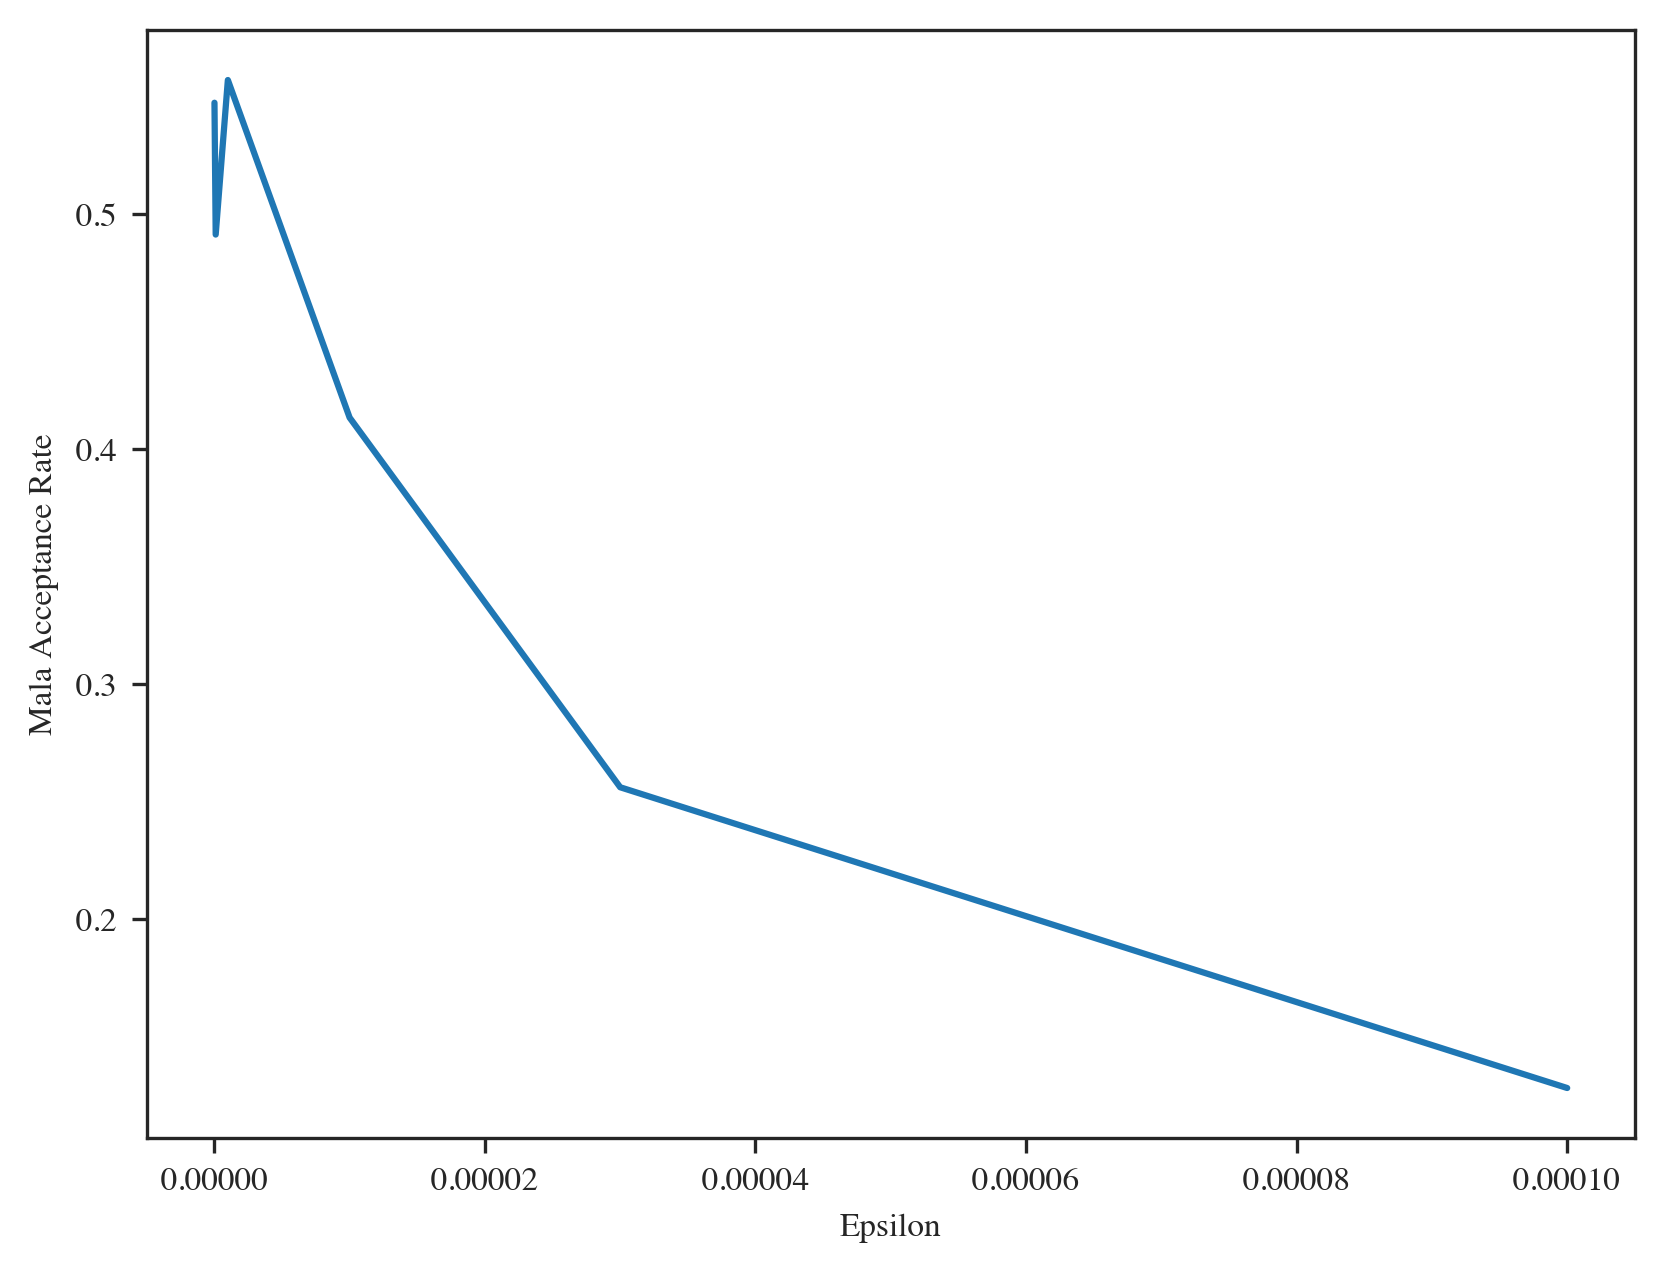

In [95]:
mala_for_eps = []
for i in range(len(all_mala_rates_for_eps)):
    mala_for_eps.append(all_mala_rates_for_eps[i][1])
    
plt.plot(EPSILONS, mala_for_eps)
plt.ylabel('Mala Acceptance Rate')
plt.xlabel('Epsilon')
seaborn.set_style("ticks")
plt.rcParams["font.family"] = "Times"
plt.rcParams['figure.dpi'] = 300
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('axes', labelsize=8)
plt.rc('legend', fontsize=8)
plt.rc('axes', titlesize=10)
plt.show()

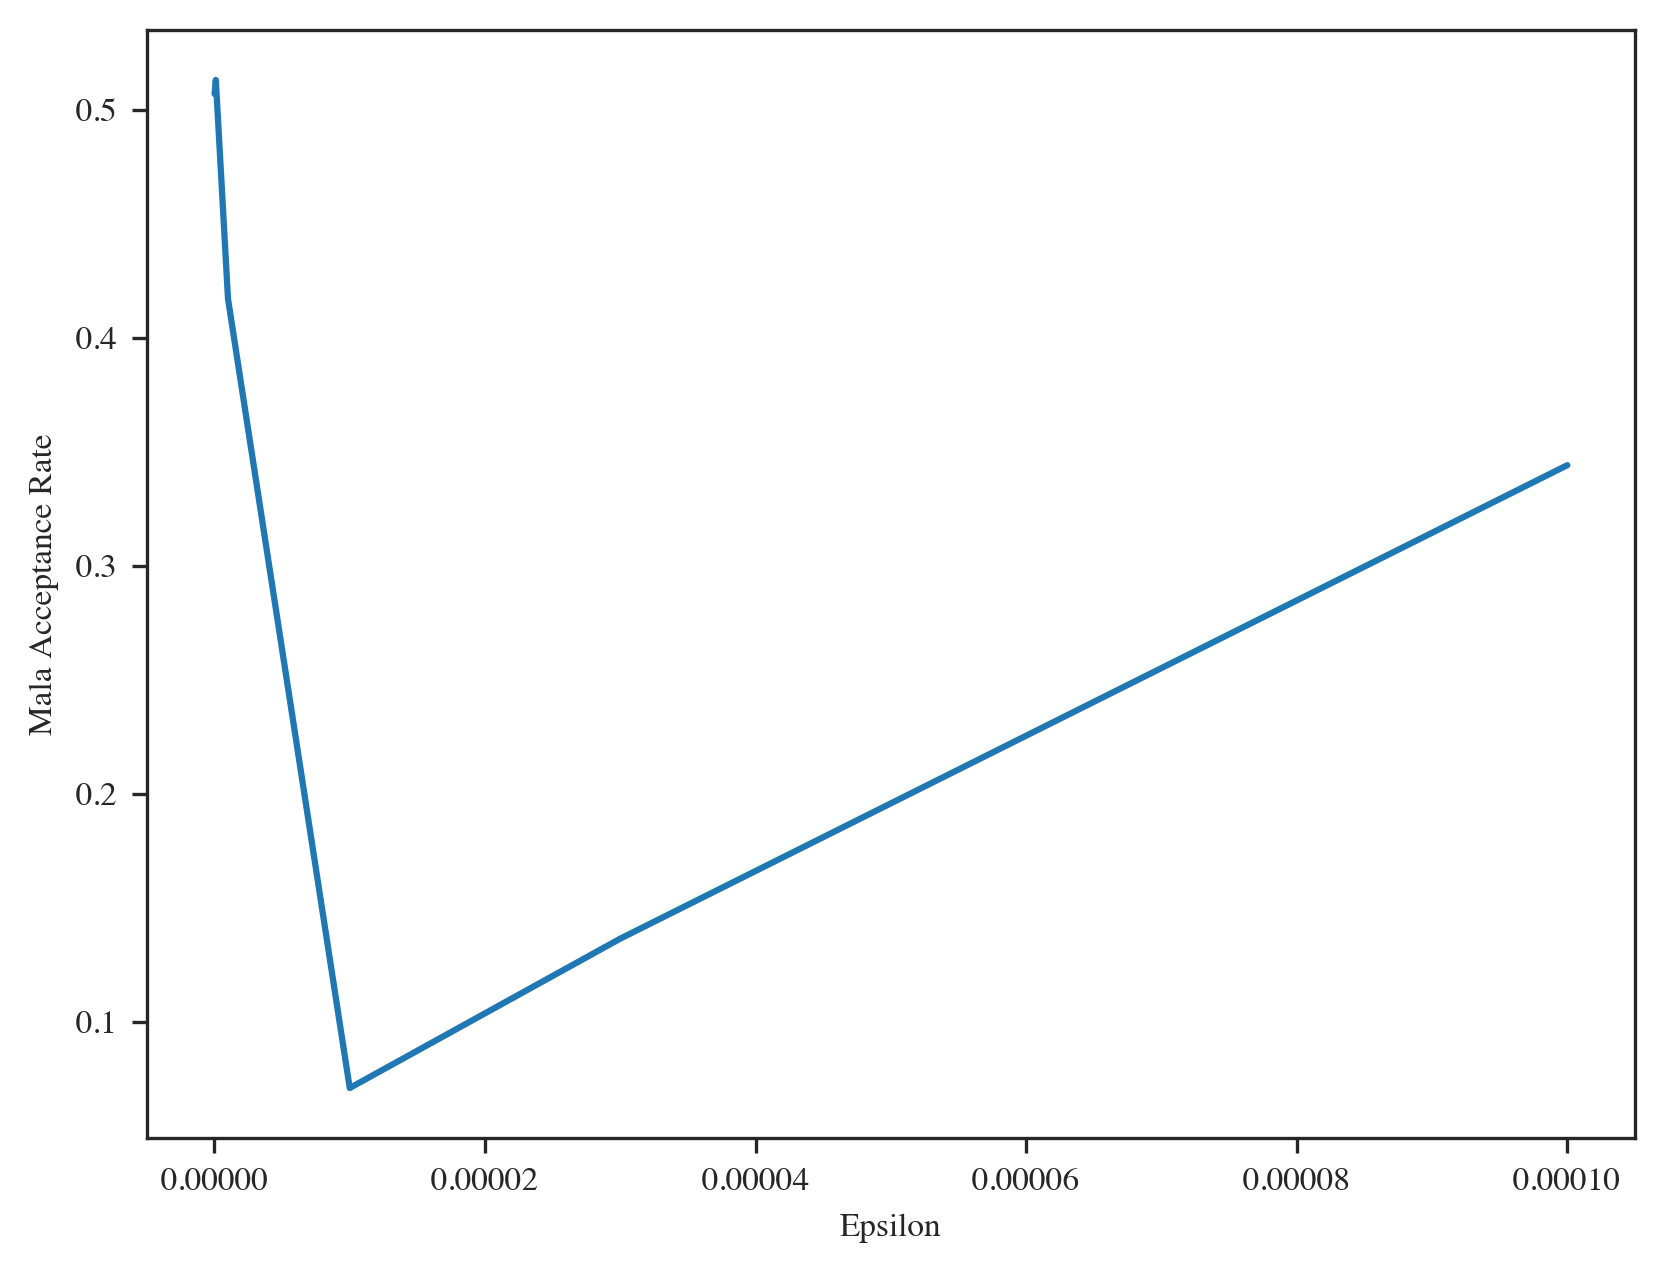

In [96]:
mala_for_eps = []
for i in range(len(all_mala_rates_for_eps)):
    mala_for_eps.append(all_mala_rates_for_eps[i][2])
    
plt.plot(EPSILONS, mala_for_eps)
plt.ylabel('Mala Acceptance Rate')
plt.xlabel('Epsilon')
seaborn.set_style("ticks")
plt.rcParams["font.family"] = "Times"
plt.rcParams['figure.dpi'] = 300
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('axes', labelsize=8)
plt.rc('legend', fontsize=8)
plt.rc('axes', titlesize=10)
plt.show()

In [17]:
EPSILONS = [1e-4, 3e-5, 1e-5, 1e-6, 1e-7, 1e-8]
GAMMAS = [1.0, 10.0, 100.0]

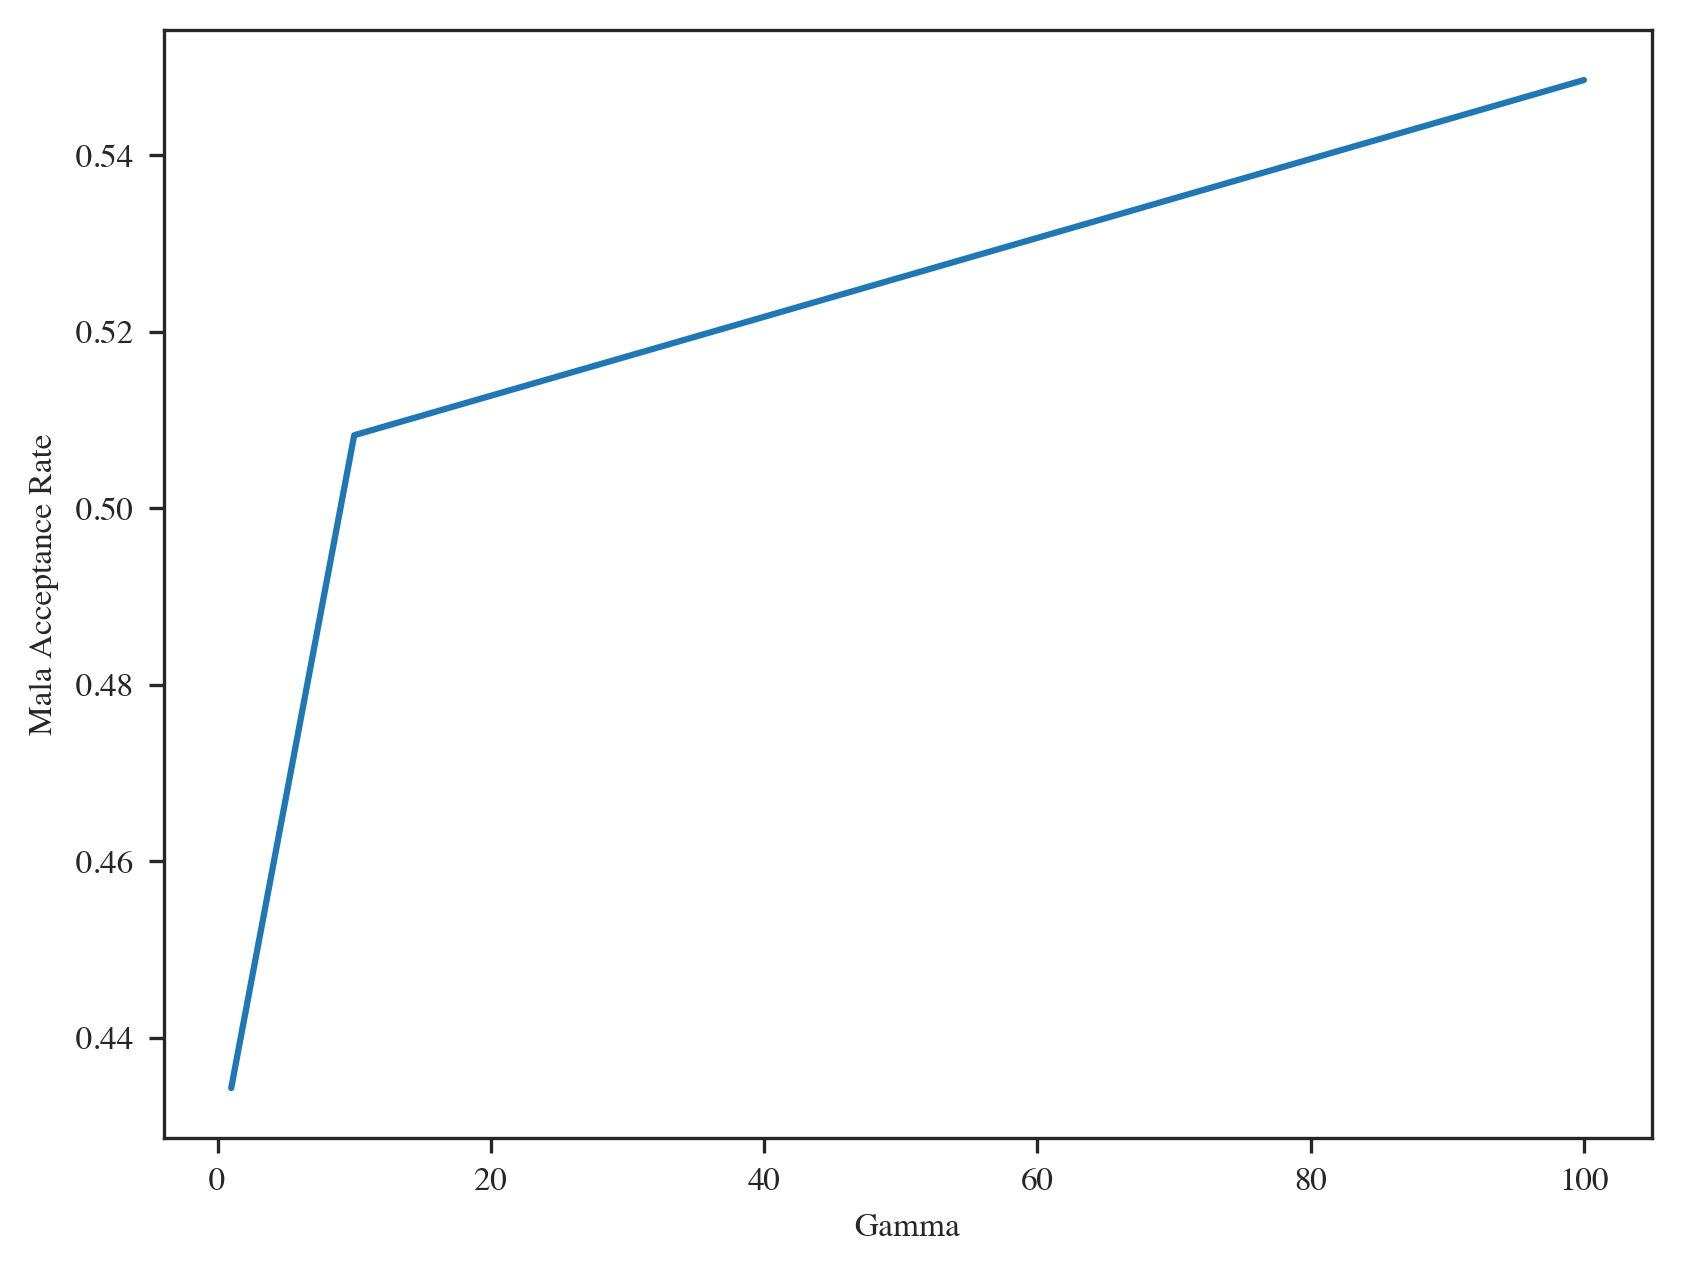

In [97]:
mala_for_gams = []
for i in range(len(all_mala_rates_for_gams)):
    mala_for_gams.append(all_mala_rates_for_gams[i][0])
    
plt.plot(GAMMAS, mala_for_gams)
plt.ylabel('Mala Acceptance Rate')
plt.xlabel('Gamma')
seaborn.set_style("ticks")
plt.rcParams["font.family"] = "Times"
plt.rcParams['figure.dpi'] = 300
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('axes', labelsize=8)
plt.rc('legend', fontsize=8)
plt.rc('axes', titlesize=10)
plt.show()

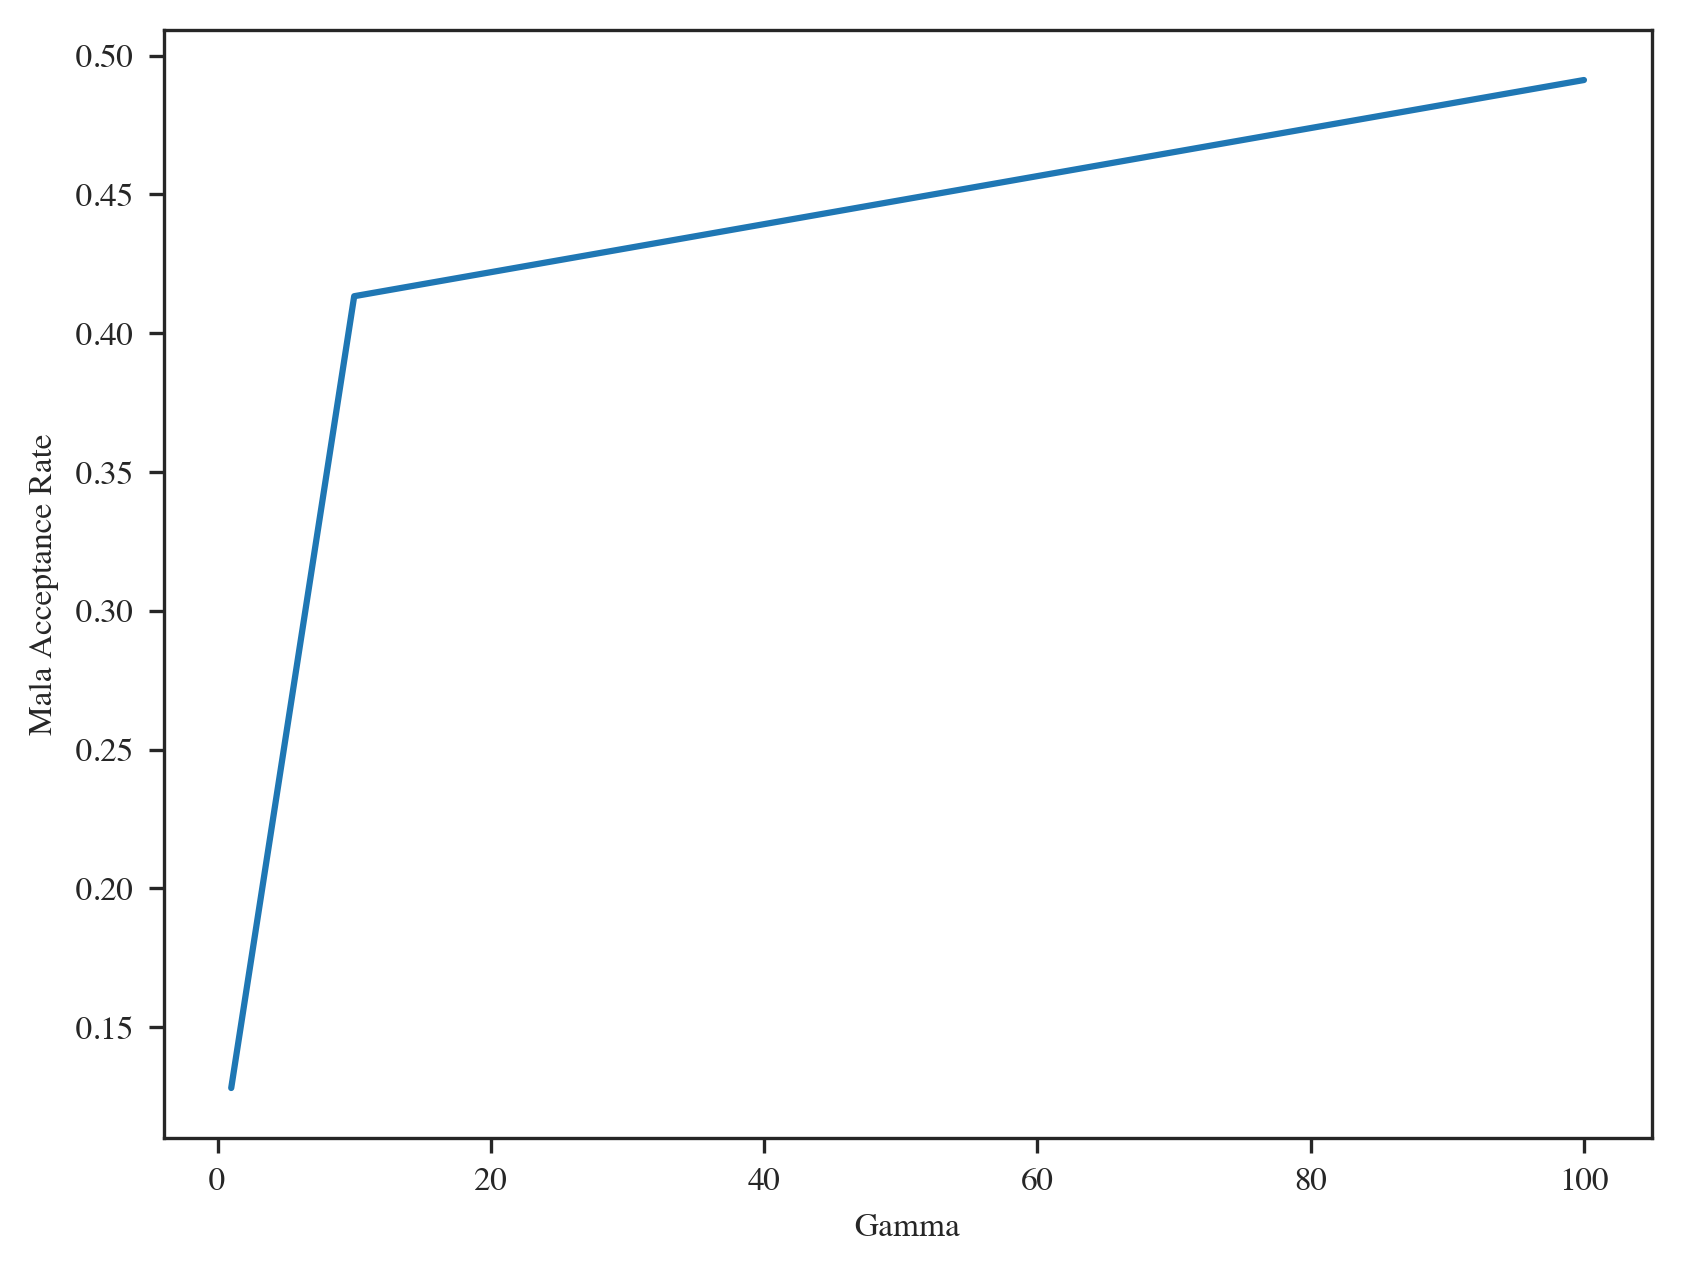

In [98]:
mala_for_gams = []
for i in range(len(all_mala_rates_for_gams)):
    mala_for_gams.append(all_mala_rates_for_gams[i][1])
    
plt.plot(GAMMAS, mala_for_gams)
plt.ylabel('Mala Acceptance Rate')
plt.xlabel('Gamma')
seaborn.set_style("ticks")
plt.rcParams["font.family"] = "Times"
plt.rcParams['figure.dpi'] = 300
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('axes', labelsize=8)
plt.rc('legend', fontsize=8)
plt.rc('axes', titlesize=10)
plt.show()

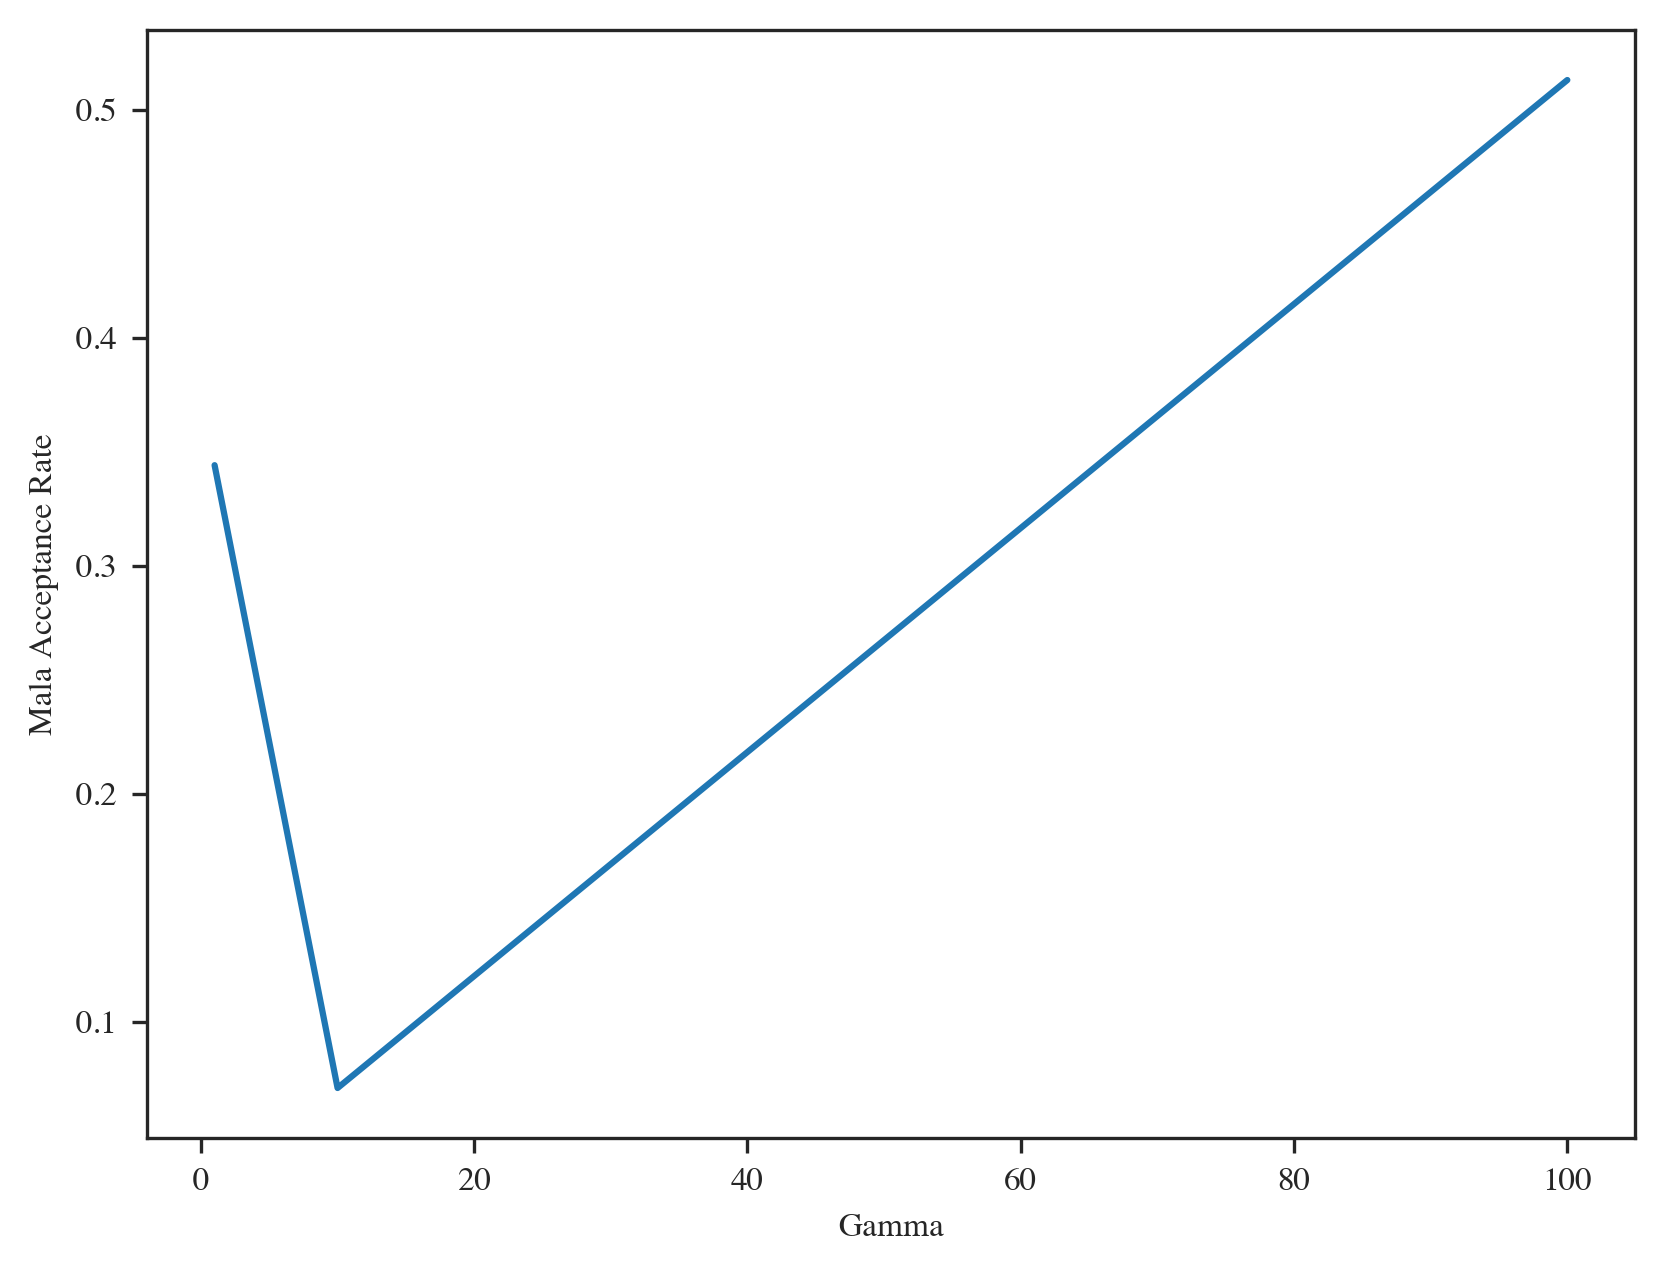

In [99]:
mala_for_gams = []
for i in range(len(all_mala_rates_for_gams)):
    mala_for_gams.append(all_mala_rates_for_gams[i][2])
    
plt.plot(GAMMAS, mala_for_gams)
plt.ylabel('Mala Acceptance Rate')
plt.xlabel('Gamma')
seaborn.set_style("ticks")
plt.rcParams["font.family"] = "Times"
plt.rcParams['figure.dpi'] = 300
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('axes', labelsize=8)
plt.rc('legend', fontsize=8)
plt.rc('axes', titlesize=10)
plt.show()